# Ensemble of Selection Functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils.dataviz import setup_color, mollview, mycolor
from lssutils.stats.nnbar import get_meandensity, hist
from lssutils.stats.cl import get_cl
import lssutils.utils as ut
import healpy as hp
import fitsio as ft
from lssutils.lab import AnaFast
from glob import glob
from scipy.stats import binned_statistic
import corner
from getdist import plots, MCSamples

In [2]:
setup_color()

## MCMC linear 

In [3]:
class Chains:
    
    def __init__(self, filename, plot=False):
    
        chains_ = np.load(filename, allow_pickle=True)
        self.chains = chains_['chain']
        self.stats = {'x':chains_['x'], 'y':chains_['y']}
        print(self.chains.shape)
        self.ndim = self.chains.shape[-1]

        if plot:
            fg, ax = plt.subplots(nrows=self.ndim, figsize=(8, self.ndim*1), sharex=True)#, sharey=True)
            ax = ax.flatten()
            #ax[0].set_ylim(-.5, .5)

            for i, ix in enumerate(range(self.ndim)): #[0, 1, 2, 3, 5]):
                for j in range(400):
                    ax[i].plot(self.chains[:, j, ix])

                ax[i].axhline(0.0, ls=':')    
            fg.show()
        
    def get_sample(self, skip_rows=400):
        return self.chains[skip_rows:, :, :].reshape(-1, self.ndim)

In [4]:
ch1 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/mcmc_sdecals_1024.npz')
ch2 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/mcmc_ndecals_1024.npz')
ch3 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/mcmc_bmzls_1024.npz')

(1000, 400, 12)
(1000, 400, 12)
(1000, 400, 12)


In [5]:
s1 = ch1.get_sample(skip_rows=400)
s2 = ch2.get_sample(skip_rows=400)
s3 = ch3.get_sample(skip_rows=400)

In [6]:
columns = np.array(['c', 'EBV', 'star']\
          + [f'galdepth-{b}' for b in ['r', 'g', 'z']]\
          + [f'psfdepth-{b}' for b in ['r', 'g', 'z']]\
          + [f'psfsize-{b}' for b in ['r', 'g', 'z']]) # 
len(columns)

12

In [23]:
ix = [0, 1, 4, 9]

In [13]:
# samples1 = MCSamples(samples=s1[:, ix], names=columns[ix], labels=columns[ix], label='DECaLS South')
# samples2 = MCSamples(samples=s2[:, ix], names=columns[ix], labels=columns[ix], label='DECaLS North')
# samples3 = MCSamples(samples=s3[:, ix], names=columns[ix], labels=columns[ix], label='BASS/MzLS')
# # Triangle plot
# g = plots.get_subplot_plotter()
# g.triangle_plot([samples3, samples2, samples1], filled=True)

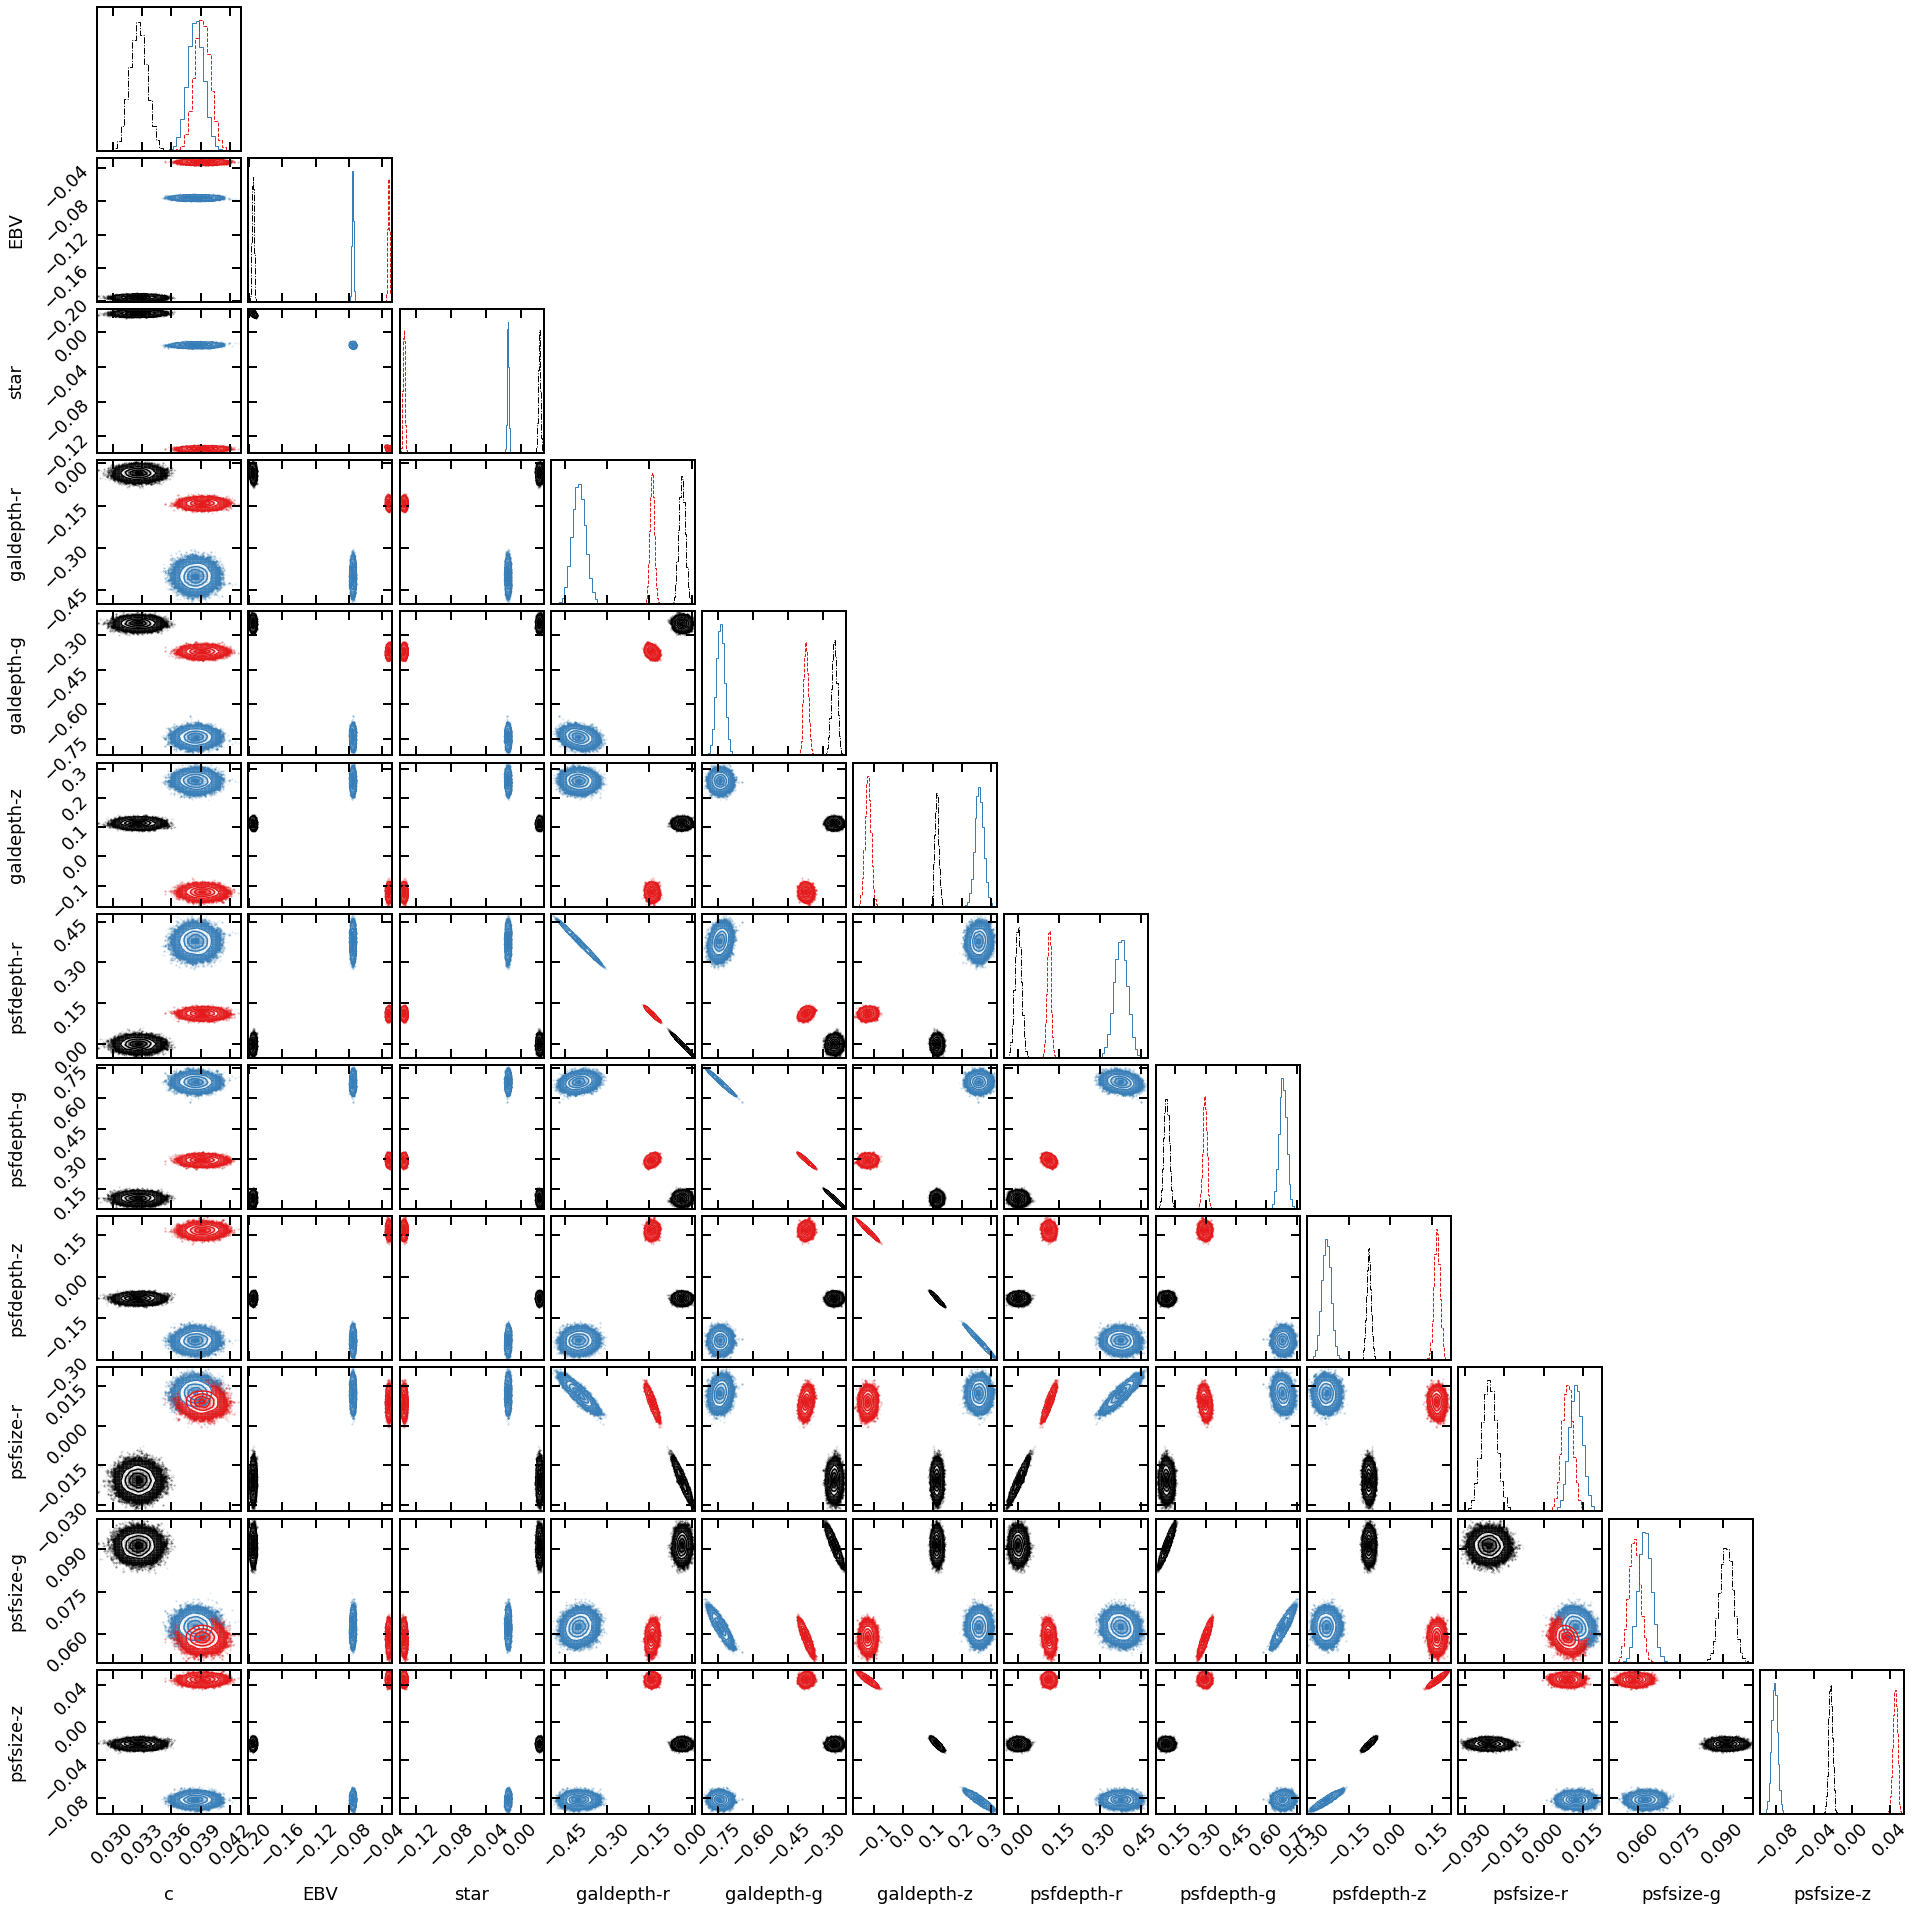

In [22]:
fg = corner.corner(s1, labels=columns, color='C2', group='sdecals')
corner.corner(s2, labels=columns, color='C1', fig=fg, group='ndecals')
corner.corner(s3, labels=columns, color='C0', fig=fg, group='bmzls', labelpad=0.2)
# fg.legend()
fg.align_labels()
plt.show()

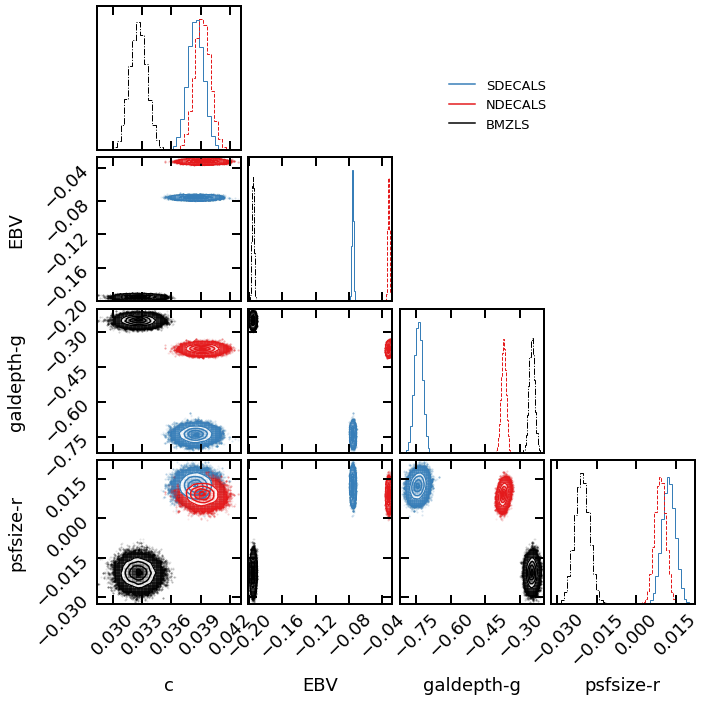

In [28]:
import matplotlib.lines as mlines

l1 = mlines.Line2D([], [], color='C2', label='SDECALS')
l2 = mlines.Line2D([], [], color='C1', label='NDECALS')
l3 = mlines.Line2D([], [], color='C0', label='BMZLS')



ix = [0, 1, 4, 9]
fg = corner.corner(s1[:, ix], labels=columns[ix], color='C2', group='sdecals')
corner.corner(s2[:, ix], labels=columns[ix], color='C1', fig=fg, group='ndecals')
corner.corner(s3[:, ix], labels=columns[ix], color='C0', fig=fg, group='bmzls', labelpad=0.2)

fg.legend(handles=[l1, l2, l3], bbox_to_anchor=(0., 0.8, 0.8, .0), loc=4)
fg.align_labels()
fg.savefig('mcmc.pdf', bbox_inches='tight')

## Fpix

In [3]:
regions = ['bmzls', 'ndecals', 'sdecals']
fpix = {}
for region in regions:
    df_ = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')
    fpix[region] = ut.make_hp(1024, df_['hpix'], df_['fracgood'])

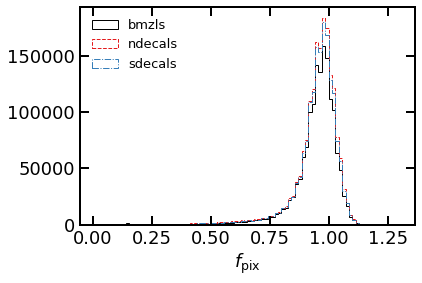

In [27]:
for region in regions:
    plt.hist(fpix[region], label=region, bins=90, histtype='step', range=(0.01, 1.3))
plt.xlabel(r'$f_{\rm pix}$')
plt.legend(loc=2)
# plt.yscale('log')
# plt.ylim()

In [30]:
fpix_map = np.zeros(12*1024*1024)

for region in regions:
    fpix_map += fpix[region]

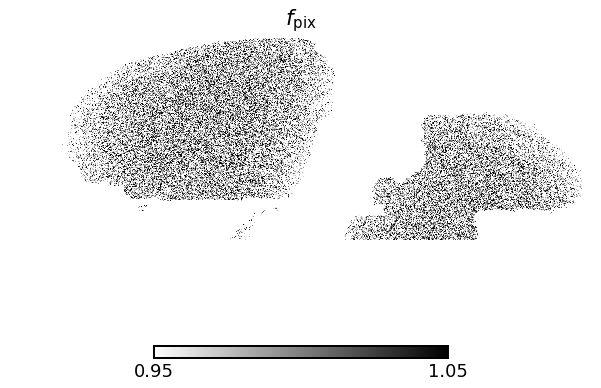

In [41]:
hp.mollview(fpix_map, rot=120, min=0.95, max=1.05, cmap=plt.cm.binary, title=r'$f_{\rm pix}$')

In [42]:
hp.write_map('fpix_map.hp1024.fits', fpix_map, fits_IDL=False, dtype=np.float64)

In [43]:
!gzip fpix_map.hp1024.fits

In [44]:
ls

cl_sg_green_sfd.npz                     LinEnsemble-weighted.ipynb
cl_sg_lenz_green_sfd.npz                logHIvsHI.ipynb
clustering_elg1024dr9.ipynb             meanden_ebv_windows.pdf
clustering_sepvsfull.ipynb              nn_windows.pdf
cross_correlation_nonlinear-1024.ipynb  power_templates.ipynb
cross_correlation_nonlinear.ipynb       pscell_dr9elg.pdf
Ensemble.ipynb                          pscell_windows.pdf
EnsembleWindows.ipynb                   selection_functions.ipynb
fpix_map.hp1024.fits.gz                 split_test.ipynb
GaussianMocks.ipynb                     TestCoordinatesNside.ipynb
LinEnsemble.ipynb                       Window_Vs_Mask.ipynb


## Windows

In [3]:
ws0 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nn*.fits')
ws0 = np.random.permutation(ws0)
len(ws0), ws0[:5]

(1000,
 array(['/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nnwindow_224.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nnwindow_274.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nnwindow_580.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nnwindow_902.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nnwindow_322.hp1024.fits'],
       dtype='<U76'))

In [4]:
ws1 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/lin*.fits')
ws1 = np.random.permutation(ws1)
len(ws1), ws1[:5]

(1000,
 array(['/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/linwindow_718.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/linwindow_887.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/linwindow_350.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/linwindow_236.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/linwindow_293.hp1024.fits'],
       dtype='<U80'))

In [5]:
d0 = []
d1 = []
kw = dict(verbose=False, dtype=np.float32)

for i in range(100):

    d0.append(hp.read_map(ws0[i], **kw))
    d1.append(hp.read_map(ws1[i], **kw))
    
    print('.', end='')

....................................................................................................

## mollweide window

<ipython-input-54-9006cecff0c0>:25: RuntimeWarning: invalid value encountered in subtract
  image2 = mollview(d_i-d_i1, -1, 1, '', figax=[fig, ax_i3], cmap=plt.cm.bwr)


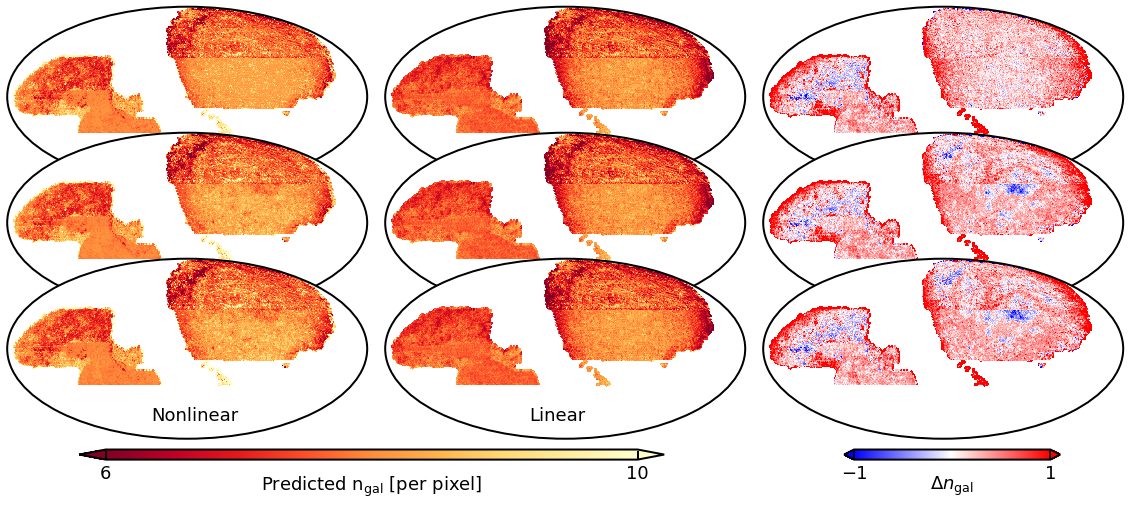

In [54]:
fig = plt.figure(figsize=(5, 7))
ax0  = fig.add_axes([0, 0, 1., 1],       projection='mollweide')
ax1  = fig.add_axes([0., -0.25, 1., 1], projection='mollweide')
ax2  = fig.add_axes([0., -0.50, 1., 1], projection='mollweide')

ax3  = fig.add_axes([1.05, 0, 1., 1],       projection='mollweide')
ax4  = fig.add_axes([1.05, -0.25, 1., 1], projection='mollweide')
ax5  = fig.add_axes([1.05, -0.50, 1., 1], projection='mollweide')

ax6  = fig.add_axes([2.1, 0, 1., 1],       projection='mollweide')
ax7  = fig.add_axes([2.1, -0.25, 1., 1], projection='mollweide')
ax8  = fig.add_axes([2.1, -0.50, 1., 1], projection='mollweide')

for i, (ax_i1, ax_i2, ax_i3) in enumerate(zip([ax0, ax1, ax2], 
                                              [ax3, ax4, ax5],
                                              [ax6, ax7, ax8])):
    d_i = d0[i]*1.0
    d_i[d_i==0] = np.inf
    image0 = mollview(d_i, 6, 10, '', figax=[fig, ax_i1], cmap=plt.cm.YlOrRd_r)

    d_i1 = d1[i]*1.0
    d_i1[d_i1==0] = np.inf
    image1 = mollview(d_i1, 6, 10, '', figax=[fig, ax_i2], cmap=plt.cm.YlOrRd_r)
    
    image2 = mollview(d_i-d_i1, -1, 1, '', figax=[fig, ax_i3], cmap=plt.cm.bwr)
    
    ax_i1.set(xticks=[], yticks=[])
    ax_i2.set(xticks=[], yticks=[])
    ax_i3.set(xticks=[], yticks=[])
    
    
    
cax = plt.axes([0.2, -0.22, 1.625, 0.02])  # horizontal
cb  = fig.colorbar(image0, cax=cax, label=r'Predicted n$_{{\rm gal}}$ [per pixel]', fraction=0.15,
                   shrink=0.6, ticks=[6, 10],
                   orientation='horizontal', extend='both')        
cb.ax.xaxis.labelpad = -8
cb.solids.set_edgecolor("face")


cax = plt.axes([2.325, -0.22, 0.6, 0.02])  # horizontal
cb  = fig.colorbar(image2, cax=cax, label=r'$\Delta n_{{\rm gal}}$', fraction=0.15,
                   shrink=0.6, ticks=[-1, 1],
                   orientation='horizontal', extend='both')        
cb.ax.xaxis.labelpad = -8
cb.solids.set_edgecolor("face")


ax2.text(0.4, 0.1, 'Nonlinear', transform=ax2.transAxes)
ax5.text(0.4, 0.1, 'Linear', transform=ax5.transAxes)

fig.savefig('nn_windows.pdf', bbox_inches='tight')

## Mean Density

In [7]:
regions = ['bmzls', 'ndecals', 'sdecals']
df = {}

for region in regions:
    df[region] = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')

In [8]:
ng_data = {}

for region in regions:
    ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    st_ = ut.make_hp(1024, df[region]['hpix'], df[region]['features'][:, 0])[:, np.newaxis]
    
    ng_data[region] = get_meandensity(ng_, fr_, ms_, st_, njack=20)
    print(region)

bmzls
ndecals
sdecals


In [10]:
ng_wind0 = {}
ng_wind1 = {}

for region in regions:
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    st_ = ut.make_hp(1024, df[region]['hpix'], df[region]['features'][:, 0])#[:, np.newaxis]

    ng_wind = []
    for d_i in d0:
        d_ij = d_i*1.0
        d_ij = d_ij / np.median(d_ij[ms_])
        d_ij = d_ij.clip(0.5, 2.0)
        ng_wind.append(hist((d_ij*fr_)[ms_], fr_[ms_], st_[ms_], bins=ng_data[region][0]['bin_edges']))
        print('.', end='')
    ng_wind0[region] = ng_wind
    print('')
    
    ng_wind = []
    for d_i in d1:
        d_ij = d_i*1.0
        d_ij = d_ij / np.median(d_ij[ms_])
        d_ij = d_ij.clip(0.5, 2.0)
        ng_wind.append(hist((d_ij*fr_)[ms_], fr_[ms_], st_[ms_], bins=ng_data[region][0]['bin_edges']))
        print('.', end='')
        
    ng_wind1[region] = ng_wind       
    print(region)

....................................................................................................
....................................................................................................bmzls
....................................................................................................
....................................................................................................ndecals
....................................................................................................
....................................................................................................sdecals


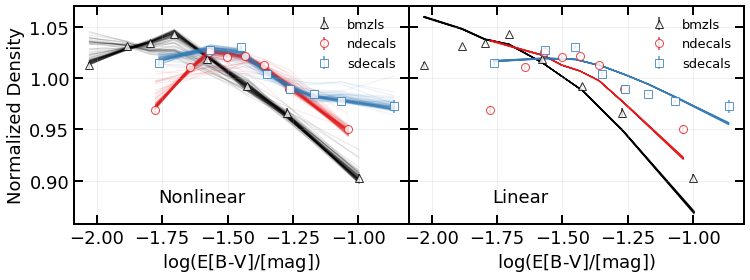

In [17]:
def add_plot(ax, ng_data, nb_winds, text=''):
    
    mk = ['^', 'o', 's']

    i = 0
    for n_i, ng_i in ng_data.items():
        ln = ax.errorbar(np.log10(ng_i[0]['bin_avg']), ng_i[0]['nnbar'], yerr=ng_i[0]['nnbar_err'], 
                         marker=mk[i], markersize=8, mfc='w', alpha=0.8, ls='None', label=n_i)
        i += 1
        for ng_j in nb_winds[n_i]:
            ax.plot(np.log10(ng_j[0]), ng_j[1], color=ln[0].get_color(), 
                    ls='-', lw=1, alpha=0.1, zorder=-10)

    ax.set(xlabel=r'$\log$(E[B-V]/[mag])') # ylim=(0.89, 1.05), 
    ax.legend()
    ax.grid(lw=1, alpha=0.2)
    ax.text(0.25, 0.1, text, transform=ax.transAxes)
    

    
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.0)


add_plot(ax[0], ng_data, ng_wind0, 'Nonlinear')
add_plot(ax[1], ng_data, ng_wind1, 'Linear')
ax[0].set_ylabel('Normalized Density')

fg.savefig('meanden_ebv_windows.pdf', bbox_inches='tight')

## Angular Power

In [8]:
cl_data = {}

for region in regions:
    ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    
    cl_data[region] = get_cl(ng_, fr_, ms_, njack=0)
    print(region)

bmzls
ndecals
sdecals


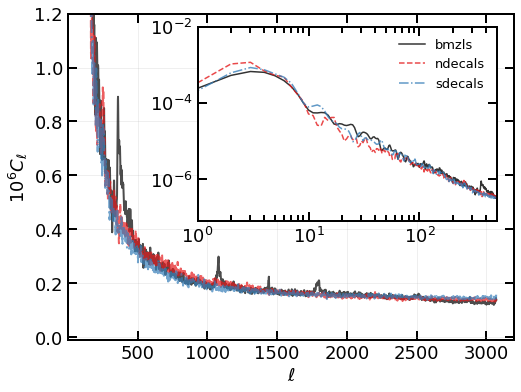

In [88]:
fg, ax = plt.subplots(figsize=(8, 6))
ax1 = fg.add_axes([0.35, 0.4, 0.52, 0.45])


for n, cl_i in cl_data.items():
    ax.plot(1.0e6*cl_i['cl_gg']['cl'], alpha=0.7, label=n, lw=2)
    ax1.plot(cl_i['cl_gg']['cl'], alpha=0.8, label=n)

    
ax1.legend(loc='upper right')
ax.grid(lw=1, alpha=0.2, which='both')
ax1.set(xlim=(1., 500.), ylim=(8.0e-8, 1.0e-2), xscale='log', yscale='log')
ax.set(xlim=(1, 3200), ylim=(-1.0e-2, 1.2), ylabel=r'$10^{6}C_{\ell}$', xlabel=r'$\ell$')

fg.savefig('cl_dr9elg.pdf', bbox_inches='tight')

In [3]:
def loadcl(filename):
    c_ = np.load(filename, allow_pickle=True)
    return np.concatenate(c_.flatten())

cl_wlin = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_wlin[reg] = loadcl(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/cell_{reg}.npy')

In [4]:
cl_wnn = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_wnn[reg] = loadcl(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/cell_{reg}.npy')

In [5]:
from matplotlib.gridspec import GridSpec

'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


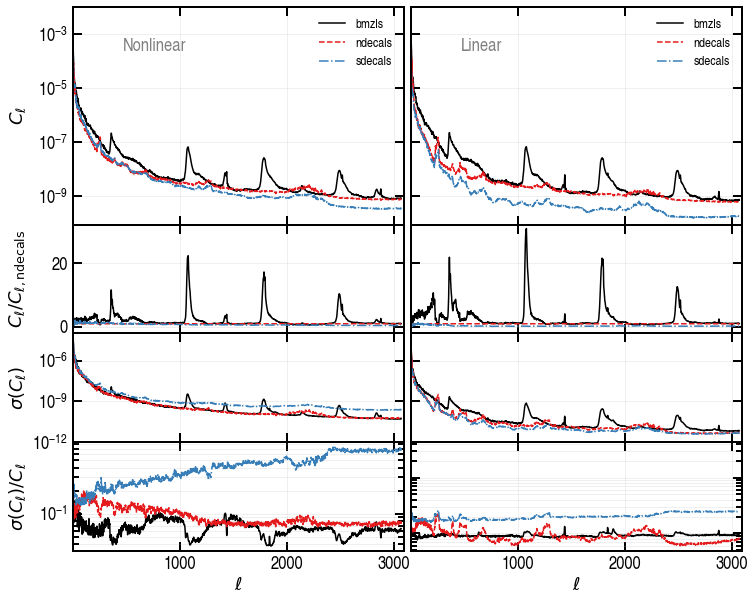

In [11]:
def add_plot(ax1, ax3, ax5, ax7, nb_winds, text=''):
    
    mk = ['^', 'o', 's']
    colors = ['C0', 'C1', 'C2']
    cl_ndec = np.mean(nb_winds['ndecals'], axis=0)
    
    for i, n_i in enumerate(['bmzls','ndecals', 'sdecals']):
        
        cl_mean = np.mean(nb_winds[n_i], axis=0)
        cl_std  = np.std(nb_winds[n_i], axis=0)
        #for ng_j in nb_winds[n_i]:    
        #    ax.plot(ng_j, color=colors[i], 
        #            ls='-', lw=1, alpha=0.1, zorder=-10)
            
        ax1.plot(cl_mean, color=colors[i], label=n_i)
        ax3.plot(cl_mean/cl_ndec, color=colors[i])
        ax5.plot(cl_std, color=colors[i])
        ax7.plot(cl_std/cl_mean, color=colors[i])
    

    ax1.legend(loc='upper right')
    ax1.set(yscale='log', xlim=(1.0, 3100), ylim=(9.0e-11, 1.0e-2))
    ax3.set(xlim=(1.0, 3100), xlabel=r'$\ell$', ylim=(-2, 32.0))
    #     ax3.set_yscale('symlog', linthresh=10)
    ax5.set(xlim=(1.0, 3100), yscale='log', ylim=(1.0e-12, 1.0e-4))    
    ax7.set(xlabel=r'$\ell$', xlim=(1.0, 3100.), yscale='log')
    
    for ax in [ax1, ax3, ax5, ax7]:
        ax.grid(lw=1, alpha=0.2, which='both')
    ax1.text(0.15, 0.8, text, color='grey', transform=ax1.transAxes)
    

    
#fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
#fg.subplots_adjust(wspace=0.0)
fig = plt.figure(figsize=(12, 10), constrained_layout=False)
gs = GridSpec(5, 2, figure=fig)

ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3, 1])
ax7 = fig.add_subplot(gs[4, 0])
ax8 = fig.add_subplot(gs[4, 1])


for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.tick_params(labelbottom=False)
for ax in [ax2, ax4, ax6, ax8]:
    ax.tick_params(labelleft=False)
    

fig.subplots_adjust(hspace=0.0, wspace=0.02)

add_plot(ax1, ax3, ax5, ax7, cl_wnn, 'Nonlinear')
add_plot(ax2, ax4, ax6, ax8, cl_wlin, 'Linear')

ax1.set_ylabel(r'$C_{\ell}$')
ax3.set_ylabel(r'$C_{\ell}/C_{\ell, {\rm ndecals}}$')
ax5.set_ylabel(r'$\sigma(C_{\ell})$')
ax7.set_ylabel(r'$\sigma(C_{\ell})/C_{\ell}$')

fig.align_labels()
fig.savefig('cl_windows.pdf', bbox_inches='tight', dpi=300)

In [ ]:
def add_plot(ax, nb_winds, text=''):
    
    mk = ['^', 'o', 's']
    colors = ['C0', 'C1', 'C2']
    
    for i, n_i in enumerate(['bmzls','ndecals', 'sdecals']):
        
        cl_mean = np.mean(nb_winds[n_i], axis=0)
        
        for ng_j in nb_winds[n_i]:
            
            ax.plot(ng_j, color=colors[i], 
                    ls='-', lw=1, alpha=0.1, zorder=-10)
            
        ax.plot(cl_mean, color=colors[i], ls='-', label=n_i)

#     ax.set(ylim=(0.3, 1.8)) #xlabel=r'$\log$(E[B-V]/[mag])') # ylim=(0.89, 1.05), 
    ax.legend(loc='upper right')
    ax.set(yscale='log', xlim=(1.0, 3100), 
           ylim=(1.0e-10, 1.0e-2), xlabel=r'$\ell$')
    ax.grid(lw=1, alpha=0.2, which='both')
    ax.text(0.15, 0.8, text, transform=ax.transAxes)
    

    
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.0)


add_plot(ax[0], ng_wind0, 'Nonlinear')
add_plot(ax[1], ng_wind1, 'Linear')
ax[0].set_ylabel(r'Pseudo $C_{\ell}$')

fg.savefig('pscell_windows.pdf', bbox_inches='tight', dpi=300)

bmzls
ndecals
sdecals


(1e-07, 0.002)

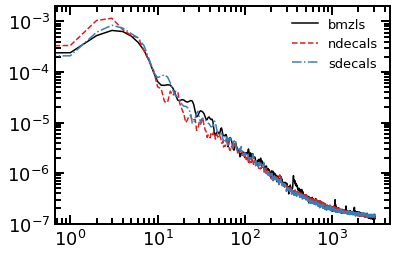

In [23]:
cl_windows = {}

for region in regions:
    #ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5

    cl_wind = []
    for d_i in d_[:20]:
        vmin, vmax = np.percentile(d_i[ms_], [1, 99])
        d_i = d_i.clip(vmin, vmax)
        cl_wind.append(get_cl(d_i*fr_, fr_, ms_, njack=0)['cl_gg']['cl'])
        print('.', end='')
        
    cl_windows[region] = cl_wind
    print(region)

....................bmzls
....................ndecals
....................sdecals


(1e-10, 0.002)

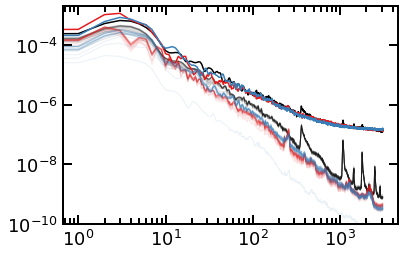

In [26]:
for reg in ['bmzls', 'ndecals', 'sdecals']:
    
    ln = plt.plot(cl_data[reg]['cl_gg']['cl'], ls='-')

    for cl_i in cl_windows[reg]:
        plt.plot(cl_i, ls='-', color=ln[0].get_color(), alpha=0.1, lw=1)
plt.loglog()
plt.ylim(1.0e-10, 2.0e-3)

In [ ]:
for n, cl_i in cl_data.items():
    plt.loglog(cl_i['cl_gg']['cl'], label=n)
    
    
    
plt.legend()
plt.ylim(1.0e-7, 2.0e-3)

In [ ]:
cl = []

for i, d_i in enum

In [ ]:
# 2. compute spectra of nn/lin windows
# 3. compute mean density of nn/lin windows

In [7]:
d = hp.read_map('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/nnwindow_0.hp1024.fits', 
                verbose=False, dtype=np.float64)

In [9]:
np.percentile(d[d!=0.0], [1, 99])

array([ 6.22025575, 10.06566978])

(array([  44141.,  103220.,  373720.,  813125., 1366143., 1344251.,
         659767.,  187529.,   60704.,   40997.]),
 array([ 6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <a list of 10 Patch objects>)

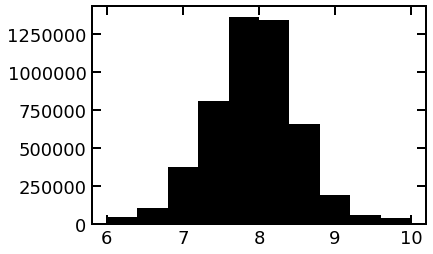

In [10]:
plt.hist(d[d!=0.0], range=(6., 10.))

In [14]:
d[d==0.0] = np.inf

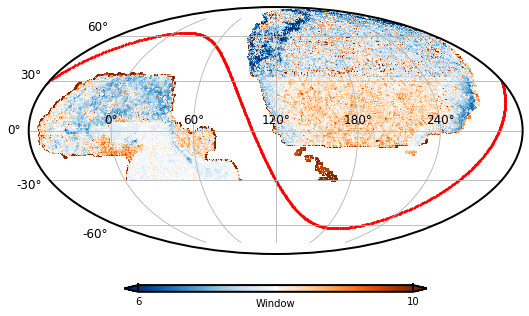

In [17]:
mollview(d, 6, 10, 'Window', galaxy=True, colorbar=True, cmap=mycolor())